# Classification

dataset: VOC2007

dataloader credit: https://github.com/lyz04551/voc2007_classification_pytorch


In [4]:
import tensorflow as tf
import numpy as np
try:
    from io import StringIO 
except ImportError:
    from io import BytesIO
import os, numpy as np
import torch
import torch.utils.data as data
!pip install -U scipy==1.2.0
from scipy.misc import imread, imresize
from scipy.sparse import csr_matrix
from PIL import Image
import xml.etree.ElementTree as ET
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
from torch import nn
from torchvision import models
import torch
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
import os, sys, numpy as np
import matplotlib.pyplot as plt
import argparse
from sklearn.metrics import average_precision_score
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.transforms as transforms
import multiprocessing

## Download Dataset

In [3]:
#!/usr/bin/env bash

! rm -rf VOCdevkit_2007
# download train
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
!tar -xf VOCtrainval_06-Nov-2007.tar
!mv VOCdevkit VOCdevkit_2007
!rm VOCtrainval_06-Nov-2007.tar

# download test
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
!tar -xf VOCtest_06-Nov-2007.tar
!mv VOCdevkit/VOC2007 VOCdevkit_2007/VOC2007test
!rmdir VOCdevkit
!rm VOCtest_06-Nov-2007.tar

--2022-04-26 02:34:18--  http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/x-tar]
Saving to: ‘VOCtrainval_06-Nov-2007.tar’

VOCtrainval_06-Nov- 100%[===================>] 438.72M  36.7MB/s    in 13s     

2022-04-26 02:34:31 (34.2 MB/s) - ‘VOCtrainval_06-Nov-2007.tar’ saved [460032000/460032000]

--2022-04-26 02:34:33--  http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 451020800 (430M) [application/x-tar]
Saving to: ‘VOCtest_06-Nov-2007.tar’

VOCtest_06-Nov-2007 100%[===================

## Dataloader

In [5]:
if torch.cuda.is_available():
    print("Using the GPU. You are good to go!")
    device = torch.device("cuda:0")
else:
    print("Using the CPU. Overall speed may be slowed down")
    device = torch.device("cpu")

Using the CPU. Overall speed may be slowed down


In [6]:
class Logger(object):

    def __init__(self, log_dir):
        """Create a summary writer logging to log_dir."""
        self.writer = tf.summary.create_file_writer(log_dir)

    def scalar_summary(self, tag, value, step):
        """Log a scalar variable."""
        summary = tf.Summary(value=[tf.Summary.Value(tag=tag, simple_value=value)])
        self.writer.add_summary(summary, step)

    def image_summary(self, tag, images, step):
        """Log a list of images."""

        img_summaries = []
        for i, img in enumerate(images):
            # Write the image to a string
            try:
                s = BytesIO()
            except:
                s = StringIO()
            scipy.misc.toimage(img).save(s, format="png")

            # Create an Image object
            img_sum = tf.Summary.Image(encoded_image_string=s.getvalue(),
                                       height=img.shape[0],
                                       width=img.shape[1])
            # Create a Summary value
            img_summaries.append(tf.Summary.Value(tag='%s/%d' % (tag, i), image=img_sum))

        # Create and write Summary
        summary = tf.Summary(value=img_summaries)
        self.writer.add_summary(summary, step)

    def histo_summary(self, tag, values, step, bins=1000):
        """Log a histogram of the tensor of values."""

        # Create a histogram using numpy
        counts, bin_edges = np.histogram(values, bins=bins)

        # Fill the fields of the histogram proto
        hist = tf.HistogramProto()
        hist.min = float(np.min(values))
        hist.max = float(np.max(values))
        hist.num = int(np.prod(values.shape))
        hist.sum = float(np.sum(values))
        hist.sum_squares = float(np.sum(values ** 2))

        # Drop the start of the first bin
        bin_edges = bin_edges[1:]

        # Add bin edges and counts
        for edge in bin_edges:
            hist.bucket_limit.append(edge)
        for c in counts:
            hist.bucket.append(c)

        # Create and write Summary
        summary = tf.Summary(value=[tf.Summary.Value(tag=tag, histo=hist)])
        self.writer.add_summary(summary, step)
        self.writer.flush()


def adjust_learning_rate(optimizer, epoch, init_lr=0.1, step=30, decay=0.1):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = init_lr * (decay ** (epoch // step))
    print('Learning Rate %f'%lr)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

In [7]:
# -*- coding: utf-8 -*-
"""
Created on Fri Aug 18 11:58:07 2017

@author: Biagio Brattoli
"""


class DataLoader(data.Dataset):
    def __init__(self,data_path,trainval,transform,random_crops=0):
        self.data_path = data_path
        self.transform = transform
        self.random_crops = random_crops
        self.trainval = trainval
        
        self.__init_classes()
        self.names, self.labels = self.__dataset_info()
    
    def __getitem__(self, index):
        x = imread(self.data_path+'/JPEGImages/'+self.names[index]+'.jpg',mode='RGB')
        x = Image.fromarray(x)
        
        scale = np.random.rand()*2+0.25
        w = int(x.size[0]*scale)
        h = int(x.size[1]*scale)
        if min(w,h)<227:
            scale = 227/min(w,h)
            w = int(x.size[0]*scale)
            h = int(x.size[1]*scale)
        
        if self.random_crops==0:
            x = self.transform(x)
        else:
            crops = []
            for i in range(self.random_crops):
                crops.append(self.transform(x))
            x = torch.stack(crops)
        
        y = self.labels[index]
        return x, y
    
    def __len__(self):
        return len(self.names)
    
    def __dataset_info(self):
        with open(self.data_path+'/ImageSets/Main/'+self.trainval+'.txt') as f:
            annotations = f.readlines()
        
        annotations = [n[:-1] for n in annotations]
        
        names  = []
        labels = []
        for af in annotations:
            if len(af)!=6:
                continue
            filename = os.path.join(self.data_path,'Annotations',af)
            tree = ET.parse(filename+'.xml')
            objs = tree.findall('object')
            num_objs = len(objs)
            
            boxes = np.zeros((num_objs, 4), dtype=np.uint16)
            boxes_cl = np.zeros((num_objs), dtype=np.int32)
            
            for ix, obj in enumerate(objs):
                bbox = obj.find('bndbox')
                # Make pixel indexes 0-based
                x1 = float(bbox.find('xmin').text) - 1
                y1 = float(bbox.find('ymin').text) - 1
                x2 = float(bbox.find('xmax').text) - 1
                y2 = float(bbox.find('ymax').text) - 1
                
                cls = self.class_to_ind[obj.find('name').text.lower().strip()]
                boxes[ix, :] = [x1, y1, x2, y2]
                boxes_cl[ix] = cls
            
            lbl = np.zeros(self.num_classes)
            lbl[boxes_cl] = 1
            labels.append(lbl)
            names.append(af)
        
        return np.array(names), np.array(labels).astype(np.float32)
    
    def __init_classes(self):
        self.classes = ('__background__','aeroplane', 'bicycle', 'bird', 'boat',
                         'bottle', 'bus', 'car', 'cat', 'chair',
                         'cow', 'diningtable', 'dog', 'horse',
                         'motorbike', 'person', 'pottedplant',
                         'sheep', 'sofa', 'train', 'tvmonitor')
        self.num_classes  = len(self.classes)
        self.class_to_ind = dict(zip(self.classes, range(self.num_classes)))
        

## Training

In [8]:
def resnet50(classes, pretrain=True):
    if pretrain:
        net = models.resnet50(pretrained=True)
    else:
        net = models.resnet50()
    net.avgpool = nn.AdaptiveAvgPool2d(1)
    net.fc = nn.Linear(net.fc.in_features, classes)
    return net

In [ ]:
CORES = 2

batch_size = 16
pascal_path = '/content/VOCdevkit_2007/VOC2007'
epochs = 10
checkpoint = 'checkpoint/'
lr = 0.001
crops = 10
iter_start = 0

def compute_mAP(labels,outputs):
    y_true = labels.cpu().numpy()
    y_pred = outputs.cpu().numpy()
    AP = []
    for i in range(y_true.shape[0]):
        AP.append(average_precision_score(y_true[i],y_pred[i]))
    return np.mean(AP)


def main():
    
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std= [0.229, 0.224, 0.225])
    
    train_transform = transforms.Compose([
            transforms.RandomResizedCrop(227),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ])
    
    val_transform = transforms.Compose([
            transforms.RandomResizedCrop(227),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ])
    # DataLoader initialize
    train_data   = DataLoader('/content/VOCdevkit_2007/VOC2007','train',transform=train_transform)
    train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                               batch_size=batch_size, 
                                               shuffle=True,
                                               num_workers=CORES)
    
    val_data   = DataLoader('/content/VOCdevkit_2007/VOC2007','val',transform=val_transform,random_crops=crops)
    val_loader = torch.utils.data.DataLoader(dataset=val_data,
                                             batch_size=batch_size, 
                                             shuffle=False,
                                             num_workers=CORES)
    
    N = len(train_data.names)
    iter_per_epoch = N//batch_size

    net = resnet50(classes = 21)
    

    criterion = nn.MultiLabelSoftMarginLoss()
    optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, net.parameters()),
                                lr=lr,momentum=0.9,weight_decay = 0.0001)
    
    if not os.path.exists(checkpoint):
        os.makedirs(checkpoint+'/train')
        os.makedirs(checkpoint+'/test')
    
    logger_train = Logger(checkpoint+'/train')
    logger_test  = Logger(checkpoint+'/test')
    
    print('Start training: lr %f, batch size %d'%(lr,batch_size))
    print('Checkpoint: '+checkpoint)
    
    # Train the Model
    steps = iter_start
    for epoch in range(iter_per_epoch*iter_start,epochs):
        adjust_learning_rate(optimizer, epoch, init_lr=lr, step=80, decay=0.1)
        
        mAP = []
        for i, (images, labels) in enumerate(train_loader):
            # images = Variable(images)
            # labels = Variable(labels)
            # images = images.cuda()
            # labels = labels.cuda()
            images, labels = images.to(device), labels.to(device)
            
            # Forward + Backward + Optimize
            optimizer.zero_grad()
            outputs = net(images)
            
            mAP.append(compute_mAP(labels.data,outputs.data))
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            loss = loss.cpu().data.numpy()
            
            if steps%100==0:
                print ('[%d/%d] %d), Loss: %.3f, mAP %.2f%%' %(epoch+1, epochs, steps, loss,100*np.mean(mAP[-20:])))
            steps += 1
        
        if epoch%5==0:
            filename = '%s/jps_%03i.pth' % (checkpoint, epoch)
            torch.save(net.state_dict(), filename)
            print ('Saved: '+checkpoint)
        
        if epoch%5==0:
            test(net,criterion,logger_test,val_loader, steps)
        
        if os.path.exists(checkpoint+'/stop.txt'):
            break

def test(net,criterion,logger,val_loader,steps):
    mAP = []
    net.eval()
    for i, (images, labels) in enumerate(val_loader):
        images = images.view((-1,3,227,227))
        images = Variable(images)
        images = images.cuda()
        
        # Forward + Backward + Optimize
        outputs = net(images)
        outputs = outputs.cpu().data
        outputs = outputs.view((-1,crops,21))
        outputs = outputs.mean(dim=1).view((-1,21))
        mAP.append(compute_mAP(labels,outputs))
    
    if logger is not None:
        logger.scalar_summary('mAP', np.mean(mAP), steps)
    print ('TESTING: %d), mAP %.2f%%' %(steps,100*np.mean(mAP)))
    net.train()


if __name__ == "__main__":
    main()



## Test

In [9]:
VOC_CLASSES = ('__background__', 'aeroplane', 'bicycle', 'bird', 'boat',
                        'bottle', 'bus', 'car', 'cat', 'chair',
                        'cow', 'diningtable', 'dog', 'horse',
                        'motorbike', 'person', 'pottedplant',
                        'sheep', 'sofa', 'train', 'tvmonitor')


In [12]:
def compute_AP(labels, outputs):
    y_true = labels
    y_pred = outputs
    AP = []
    for i in range(1, y_true.shape[1]):
      ap = average_precision_score(y_true[:, i],y_pred[:, i])
      AP.append(ap)
      print('-------  Class: {:<12}     AP: {:>8.4f}  -------'.format(VOC_CLASSES[i], ap))
    return AP

def compute_mAP(labels,outputs):
    y_true = labels
    y_pred = outputs
    AP = []

    AP.append(average_precision_score(y_true,y_pred))
    return np.mean(AP)
  
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

val_transform = transforms.Compose([
    transforms.Resize((227,227)),
    transforms.ToTensor(),
    normalize,
])

from matplotlib import pyplot as plt

val_data = DataLoader('/content/VOCdevkit_2007/VOC2007test', 'test', transform=val_transform)

net=resnet50(classes=21)
net.load_state_dict(torch.load('/content/trained.pth',map_location=torch.device('cpu')))

net.eval()

all_gt_labels= np.zeros((0,21))
all_pred_outputs = np.zeros((0,21))
for idx in range(100):
  imageidx = idx
  image=val_data[imageidx][0]

  # plt.imshow(image.T, interpolation='nearest')
  # plt.show()
  labels=val_data[imageidx][1]

  images = image.view((-1,3,227,227))
  images= images.to(device)
  output=net(images).cpu().data
  output=output.numpy()

  # boolidx = (output<0)
  # output[boolidx] = 0
  # print("output:",output)

  labels=labels.reshape((1,-1))
  # print("np.shape(output):",np.shape(output))
  # print("np.shape(labels):",np.shape(labels))
  all_gt_labels=np.vstack((all_gt_labels,labels))
  all_pred_outputs=np.vstack((all_pred_outputs,output))

AP = compute_AP(all_gt_labels, all_pred_outputs)
all_gt_labels=all_gt_labels.reshape((-1))
all_pred_outputs=all_pred_outputs.reshape((-1))
print("np.shape(all_gt_labels):",np.shape(all_gt_labels))
print("np.shape(all_pred_outputs):",np.shape(all_pred_outputs))

# print("all_gt_labels:",all_gt_labels)
# print("all_pred_outputs:",all_pred_outputs)

mAP = compute_mAP(all_gt_labels,all_pred_outputs)
print("final mAP:",mAP)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.


-------  Class: aeroplane        AP:   1.0000  -------
-------  Class: bicycle          AP:   0.9667  -------
-------  Class: bird             AP:   1.0000  -------
-------  Class: boat             AP:   1.0000  -------
-------  Class: bottle           AP:   0.7083  -------
-------  Class: bus              AP:   0.9500  -------
-------  Class: car              AP:   0.9936  -------
-------  Class: cat              AP:   0.9769  -------
-------  Class: chair            AP:   0.8066  -------
-------  Class: cow              AP:   0.8333  -------
-------  Class: diningtable      AP:   0.8583  -------
-------  Class: dog              AP:   0.9417  -------
-------  Class: horse            AP:   1.0000  -------
-------  Class: motorbike        AP:   0.7593  -------
-------  Class: person           AP:   0.9567  -------
-------  Class: pottedplant      AP:   0.6845  -------
-------  Class: sheep            AP:   1.0000  -------
-------  Class: sofa             AP:   0.6894  -------
-------  C

# Class Activation Mapping (Heatmap)

Grab the final convnet layer in ResNet and create the heatmap.

credit: http://www.snappishproductions.com/blog/2018/01/03/class-activation-mapping-in-pytorch.html.html

Source code of pytorch resnet: https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py

In [13]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = ((output.cpu()).data).numpy()
    def remove(self): self.hook.remove()


In [14]:
final_layer = net._modules.get('layer4')

activated_features = SaveFeatures(final_layer)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.


image.shape: torch.Size([3, 227, 227])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


prediction: tensor([[-10.5623, -10.2838,  -5.7518,   5.4397, -10.1440,  -8.2460,  -8.0774,
          -4.6243,  -8.9847,  -2.8015,  -4.9967,  -3.3088,  -8.1049,  -6.7609,
          -4.0979,  -3.2819,  -6.4074,  -8.5351,  -7.1907,  -7.6288,  -8.9802]])
labels: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
pred_probabilities: tensor([1.1223e-07, 1.4826e-07, 1.3780e-05, 9.9923e-01, 1.7051e-07, 1.1377e-06,
        1.3466e-06, 4.2550e-05, 5.4355e-07, 2.6336e-04, 2.9320e-05, 1.5857e-04,
        1.3102e-06, 5.0237e-06, 7.2031e-05, 1.6289e-04, 7.1538e-06, 8.5206e-07,
        3.2685e-06, 2.1091e-06, 5.4598e-07])


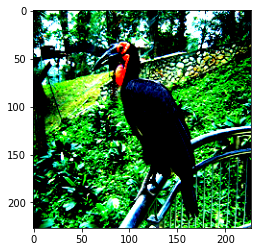

In [15]:
from torch.nn import functional as F
from torch import topk
from matplotlib.pyplot import imshow

display_transform = transforms.Compose([
   transforms.Resize((227,227))])
imageidx = 28
image=val_data[imageidx][0]
labels=val_data[imageidx][1]


print("image.shape:",image.shape)
images = image.view((-1,3,227,227))
images= images.to(device)
prediction=net(images).cpu().data
pred_probabilities = F.softmax(prediction).data.squeeze()
print("prediction:",prediction)
print("labels:",labels)
print("pred_probabilities:",pred_probabilities)
activated_features.remove()

topk(pred_probabilities,1)

img = image.swapaxes(0, 1)
img = img.swapaxes(1, 2)
imshow(img)

In [16]:
def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    print("feature_conv.shape:",feature_conv.shape)
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return [cam_img]

In [17]:
weight_softmax_params = list(net._modules.get('fc').parameters())
weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())
class_idx = topk(pred_probabilities,1)[1].int()
# class_idx = 0
print("class_idx:",class_idx)
overlay = getCAM(activated_features.features, weight_softmax, class_idx )


class_idx: tensor([3], dtype=torch.int32)
feature_conv.shape: (1, 2048, 8, 8)


(8, 8)


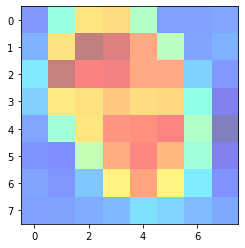

In [18]:
print(overlay[0].shape)
ov = overlay[0]
# ov = ov.swapaxes(0,1)
# imshow(overlay[0], alpha=0.5, cmap='jet')
imshow(ov, alpha=0.5, cmap='jet')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([227, 227, 3])
torch.Size([1, 3, 227, 227])


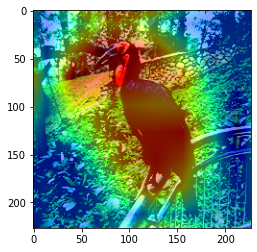

In [19]:
import skimage.transform
print(img.shape)
imshow(img)
print(images.shape)
imshow(skimage.transform.resize(ov, images.shape[2:4]), alpha=0.5, cmap='jet')

In [20]:
from PIL import Image
from matplotlib.pyplot import imshow
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
from torch import topk
import numpy as np
import skimage.transform

<class 'PIL.JpegImagePlugin.JpegImageFile'>


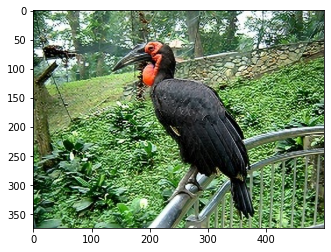

In [24]:
# high(original) resolution image in the VOC2007 test set
# image = Image.open("/content/VOCdevkit_2007/VOC2007test/JPEGImages/000057.jpg") 
# low resolution image
# image = Image.open("/content/000057-lr.jpg") 
# the output of SwinIR
image = Image.open("/content/000057-sw.jpg") 
# the output of SRCNN
# image = Image.open("/content/000057-sr.jpg") 
# the output of Bicubic Interpolation
# image = Image.open("/content/000057-bi.jpg") 

print(type(image))
imshow(image)

In [25]:
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

# Preprocessing - scale to 224x224 for model, convert to tensor, 
# and normalize to -1..1 with mean/std for ImageNet

preprocess = transforms.Compose([
  transforms.Resize((224,224)),
  transforms.ToTensor(),
  normalize
])

display_transform = transforms.Compose([
   transforms.Resize((224,224))])

In [26]:
tensor = preprocess(image)
prediction_var = Variable((tensor.unsqueeze(0)), requires_grad=True)
model = models.resnet50(pretrained=True)

In [28]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [29]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = ((output.cpu()).data).numpy()
    def remove(self): self.hook.remove()

In [30]:
final_layer = model._modules.get('layer4')
activated_features = SaveFeatures(final_layer)
prediction = model(prediction_var)
pred_probabilities = F.softmax(prediction).data.squeeze()
activated_features.remove()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.


In [31]:
topk(pred_probabilities,1)

torch.return_types.topk(values=tensor([0.9997]), indices=tensor([93]))

In [32]:
weight_softmax_params = list(model._modules.get('fc').parameters())
weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())


In [33]:
weight_softmax_params

[Parameter containing:
 tensor([[-0.0092,  0.0153, -0.0375,  ..., -0.0105,  0.0011, -0.0265],
         [ 0.0104, -0.0266,  0.0005,  ...,  0.0288, -0.0210, -0.0067],
         [-0.0072,  0.0664, -0.0393,  ...,  0.0130, -0.0249, -0.0015],
         ...,
         [-0.0104, -0.0018, -0.0348,  ..., -0.0170,  0.1071,  0.0277],
         [-0.0168, -0.0059, -0.0287,  ..., -0.0214, -0.0048, -0.0133],
         [-0.0215,  0.0239,  0.0809,  ...,  0.0010, -0.0440,  0.0180]],
        requires_grad=True), Parameter containing:
 tensor([-9.0540e-03, -4.1489e-03, -2.0516e-02, -1.7642e-02,  9.6078e-03,
          5.8760e-03, -1.4448e-02,  7.1637e-04,  1.4057e-03, -1.6386e-03,
         -1.2073e-02, -9.3700e-03, -1.9250e-02, -1.7166e-02, -1.1226e-02,
         -1.6972e-02, -8.1289e-03, -1.3626e-02,  8.5068e-03, -1.7855e-02,
          6.9540e-03,  1.8412e-02, -2.4812e-03,  2.4328e-03, -1.3534e-03,
          4.8874e-03,  1.0521e-02, -8.0455e-04, -6.4342e-03, -1.1446e-02,
         -1.3326e-02, -9.2675e-03, -2.502

In [34]:
class_idx = topk(pred_probabilities,1)[1].int()
overlay = getCAM(activated_features.features, weight_softmax, class_idx )

feature_conv.shape: (1, 2048, 7, 7)


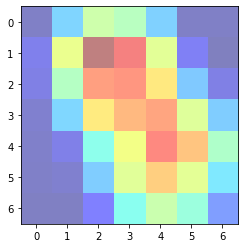

In [35]:
imshow(overlay[0], alpha=0.5, cmap='jet')

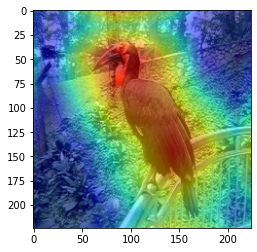

In [36]:
imshow(display_transform(image))
imshow(skimage.transform.resize(overlay[0], tensor.shape[1:3]), alpha=0.5, cmap='jet');